In [ ]:
import sys
sys.path.append('../')

In [ ]:
from pathlib import Path
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from fastai.vision.all import *
from src.unet import UNet2DModel

In [ ]:
path = Path('../data')

In [ ]:
get_image_files(path, folders=['valid', 'train'])

(#600) [Path('../data/valid/images/clodding_train_533.jpg'),Path('../data/valid/images/clodding_train_132.jpg'),Path('../data/valid/images/clodding_train_280.jpg'),Path('../data/valid/images/clodding_train_282.jpg'),Path('../data/valid/images/clodding_train_251.jpg'),Path('../data/valid/images/clodding_train_198.jpg'),Path('../data/valid/images/clodding_train_185.jpg'),Path('../data/valid/images/clodding_train_518.jpg'),Path('../data/valid/images/clodding_train_334.jpg'),Path('../data/valid/images/clodding_train_029.jpg')...]

In [ ]:
def read_yolo(file):
    res = []
    with open(file, 'r') as f:
        for l in f: res.append(np.array(l.split()[1:], dtype=np.float32).reshape(-1,2))
    return res

def create_mask(img_shape, labels):
    res = np.zeros(img_shape, dtype=np.uint8)
    h,w = img_shape
    for mask in labels: res = cv2.fillPoly(res, [(mask*(w,h)).astype(np.int32)], 255)
    return res

In [ ]:
@ItemTransform
def mask_tfm(item):
    x, y = item
    y = create_mask(x.shape, y).astype(np.float32)
    return x, TensorMask(y/255.)

@Transform
def gamma_tfm(x: TensorImage, gamma=0.7):
    return x**gamma

In [ ]:
dblock = DataBlock(blocks=(ImageBlock(PILImageBW), TransformBlock(batch_tfms=IntToFloatTensor())),
                   get_items=lambda p: get_image_files(p, folders=['valid','train']),
                   get_y=lambda o: read_yolo(str(o).replace('images', 'labels').replace('jpg','txt')),
                   splitter=GrandparentSplitter(valid_name='valid'),
                   item_tfms=[mask_tfm],
                   batch_tfms=[gamma_tfm, *aug_transforms(size=256, min_scale=0.75, max_lighting=0.2)])

In [ ]:
dls = dblock.dataloaders(path, bs=4)

In [ ]:
b = dls.one_batch()

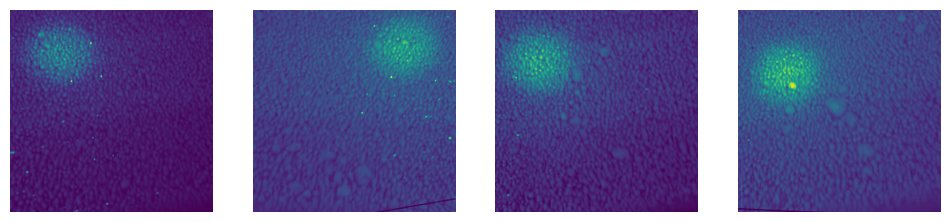

In [ ]:
show_images(b[0])

## U-net

In [ ]:
model = UNet2DModel()

In [ ]:
dls = dblock.dataloaders(path, bs=8)
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=[])

epoch,train_loss,valid_loss,time
0,0.154676,0.133456,00:13
1,0.134790,0.107192,00:12
2,0.117711,0.090519,00:12
3,0.104124,0.083213,00:12
4,0.095789,0.075713,00:13


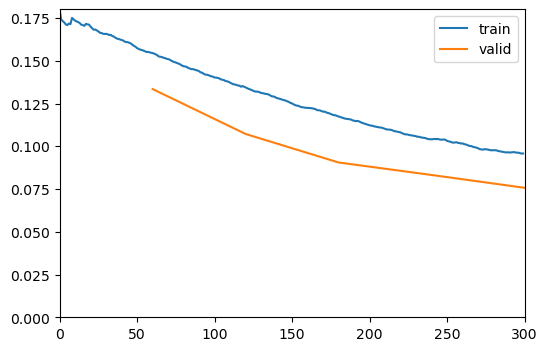

In [ ]:
learn.fit(5, cbs = [ShowGraphCallback(), MixedPrecision()])

## Inference

In [ ]:
image = cv2.imread('../data/images/clodding_train_005.jpg')

In [ ]:
def preprocess_image(image):
    gamma_tfm = Transform(lambda x: x**0.2)
    tfms = Pipeline([ToTensor(), IntToFloatTensor(), Resize(256), gamma_tfm])
    return tfms(PILImageBW.create(image))[0]

def postprocess_image(image):
    image = (image*255).numpy().astype(np.uint8)
    return cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

def decode_mask(pred, ths=0.2):
    mask = torch.sigmoid(pred[0]).cpu()
    return IntToFloatTensor().decodes(mask>ths).numpy().astype(np.uint8)

def merge_with_mask(image, mask, p=0.2, gamma=0):
    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)*np.array([0,1,0], np.uint8)
    return cv2.addWeighted(image, 1-p, mask_color, p, gamma)

In [ ]:
inp = preprocess_image(image)
res = model(to_device(inp[None,None]))
out = postprocess_image(inp)

<Axes: >

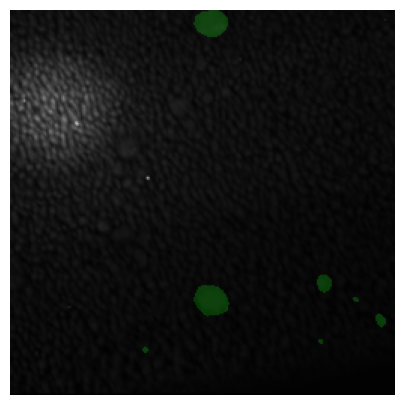

In [ ]:
show_image(merge_with_mask(out, decode_mask(res)[0]))

## Real-time

In [ ]:
def do_frame(frame):
    inp = preprocess_image(frame)
    res = model(to_device(inp[None,None]))
    out = postprocess_image(inp)
    return merge_with_mask(out, decode_mask(res, 0.4)[0])

In [ ]:
import cv2
import threading
from IPython.display import display, Image

def process_and_display(file, func=None):
    if func is None:  func = lambda x: x

    video = cv2.VideoCapture(file)
    display_handle = display(None, display_id=True)
    try:
        while True:
            _, frame = video.read()
            if frame is None: break
            _, frame = cv2.imencode('.jpeg', func(frame))
            display_handle.update(Image(data=frame.tobytes(), width=500, height=400))
    except KeyboardInterrupt:
        print('Get keyboard interrupt')
    finally:
        video.release()

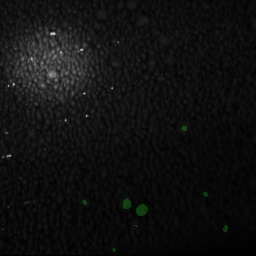

Get keyboard interrupt


In [ ]:
process_and_display('../data/clods.mp4', do_frame)